In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F31029%2F40943%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241006%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241006T175432Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db3915df1b17fe6d531d4db9b46c597c9caccfc49a8ce1d0e9307daf6dc5b84b679a0f21f1c6ee5c28c548dbf298ce89662491ad2dee50b9a2ea6d60c7c29d9eca2299828badb81c6bd17b55e5877fe4be54de3368be9a37e414449f8ee9cc59668e777e04c1c65b214aaeebc8c5cdb202332423175b50e0f5f4713786cc3af9eadf273662675f8759e083994fea9217659a0008bedf353c7641cbed6ab3660a33d83289efbcde6a2e954a6055ed96dfc7876296af2fd2d184a8eb8f2280c77b990b53ceda3696deee9d63f68a074449bdac359e6645c4687a33b283cbdaa139a9b8a21a587f21c31cb0dfbfd6f6ebde4d9a792a2bf39a7cf1348ae2040cc3661'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5690772 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


# 1. Importing the modules

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
print(os.listdir("../input"))

['noc_regions.csv', 'athlete_events.csv']


# 2. Data Importing

In [3]:
data = pd.read_csv('../input/athlete_events.csv')
regions = pd.read_csv('../input/noc_regions.csv')

# 3. Explore and Extract Information

In [4]:
data.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [5]:
data.describe()

,ID,Age,Height,Weight,Year
count,271116.000000,261642.000000,210945.000000,208241.000000,271116.000000
mean,68248.954396,25.556898,175.338970,70.702393,1978.378480
std,39022.286345,6.393561,10.518462,14.348020,29.877632
min,1.000000,10.000000,127.000000,25.000000,1896.000000
25%,34643.000000,21.000000,168.000000,60.000000,1960.000000
50%,68205.000000,24.000000,175.000000,70.000000,1988.000000
75%,102097.250000,28.000000,183.000000,79.000000,2002.000000
max,135571.000000,97.000000,226.000000,214.000000,2016.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [7]:
regions.head()

,NOC,region,notes
0,AFG,Afghanistan,NaN
1,AHO,Curacao,Netherlands Antilles
2,ALB,Albania,NaN
3,ALG,Algeria,NaN
4,AND,Andorra,NaN


# 4. Joining the dataframes

Pandas 'merge' function will help us to join these two dataframes easily.

In [8]:
merged = pd.merge(data, regions, on='NOC', how='left')

In [9]:
merged.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN


# 5. Extract data of Indian Atheletes

Let's make a new dataframe including only Indian atheletes since this notebook findinds is about India.

In [10]:
dataIndia = merged[merged.NOC == 'IND']
dataIndia.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
505,281,S. Abdul Hamid,M,NaN,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Athletics,Athletics Men's 110 metres Hurdles,NaN,India,NaN
506,281,S. Abdul Hamid,M,NaN,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Athletics,Athletics Men's 400 metres Hurdles,NaN,India,NaN
895,512,Shiny Kurisingal Abraham-Wilson,F,19.0,167.0,53.0,India,IND,1984 Summer,1984,Summer,Los Angeles,Athletics,Athletics Women's 800 metres,NaN,India,NaN
896,512,Shiny Kurisingal Abraham-Wilson,F,19.0,167.0,53.0,India,IND,1984 Summer,1984,Summer,Los Angeles,Athletics,Athletics Women's 4 x 400 metres Relay,NaN,India,NaN
897,512,Shiny Kurisingal Abraham-Wilson,F,23.0,167.0,53.0,India,IND,1988 Summer,1988,Summer,Seoul,Athletics,Athletics Women's 800 metres,NaN,India,NaN


Since we can see a lot of NaN values in the medals section. Let's filter those values out. In case where NaN values are not visible easily we can use the below method.

In [11]:
dataIndia.isnull().any()

,0
ID,False
Name,False
Sex,False
Age,True
Height,True
Weight,True
Team,False
NOC,False
Games,False
Year,False


Let's filter out NaN values. We don't need them.

In [12]:
dataIndia = dataIndia[dataIndia.Medal.notnull()]

In [13]:
dataIndia.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
4732,2699,Shaukat Ali,M,30.0,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
4736,2703,Syed Mushtaq Ali,M,22.0,165.0,61.0,India,IND,1964 Summer,1964,Summer,Tokyo,Hockey,Hockey Men's Hockey,Gold,India,NaN
5032,2864,Richard James Allen,M,25.0,172.0,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
5033,2864,Richard James Allen,M,30.0,172.0,NaN,India,IND,1932 Summer,1932,Summer,Los Angeles,Hockey,Hockey Men's Hockey,Gold,India,NaN
5034,2864,Richard James Allen,M,34.0,172.0,NaN,India,IND,1936 Summer,1936,Summer,Berlin,Hockey,Hockey Men's Hockey,Gold,India,NaN


## 6. Medals won according to year

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Distribution of Medals')

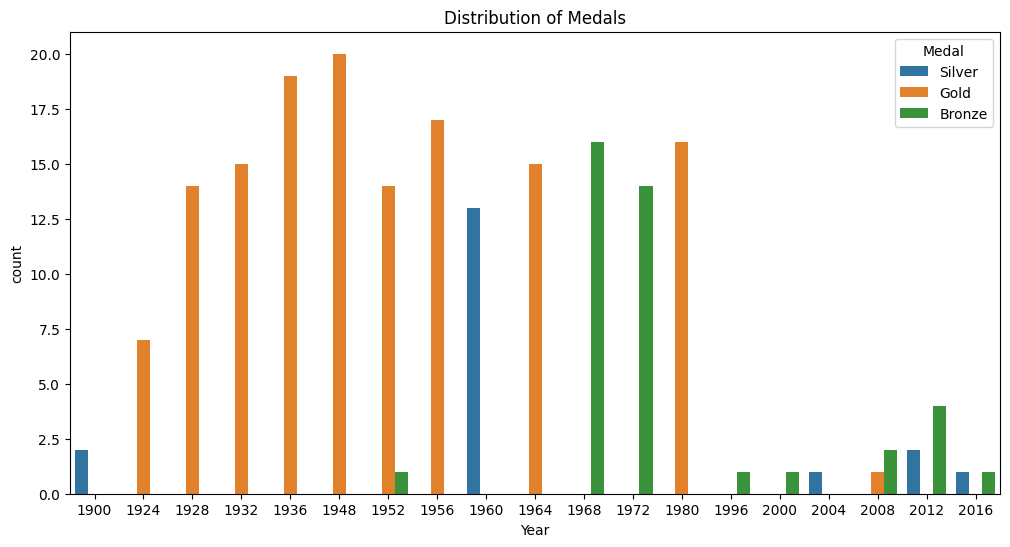

In [14]:
plt.figure(figsize=(12, 6))
plt.tight_layout()
sns.countplot(x='Year', hue='Medal', data= dataIndia)
plt.title('Distribution of Medals')

Seems like India won so many gold medals before 90s. Let's find out in which sport it won the gold medals.

Text(0.5, 1.0, 'Distribution of Medals')

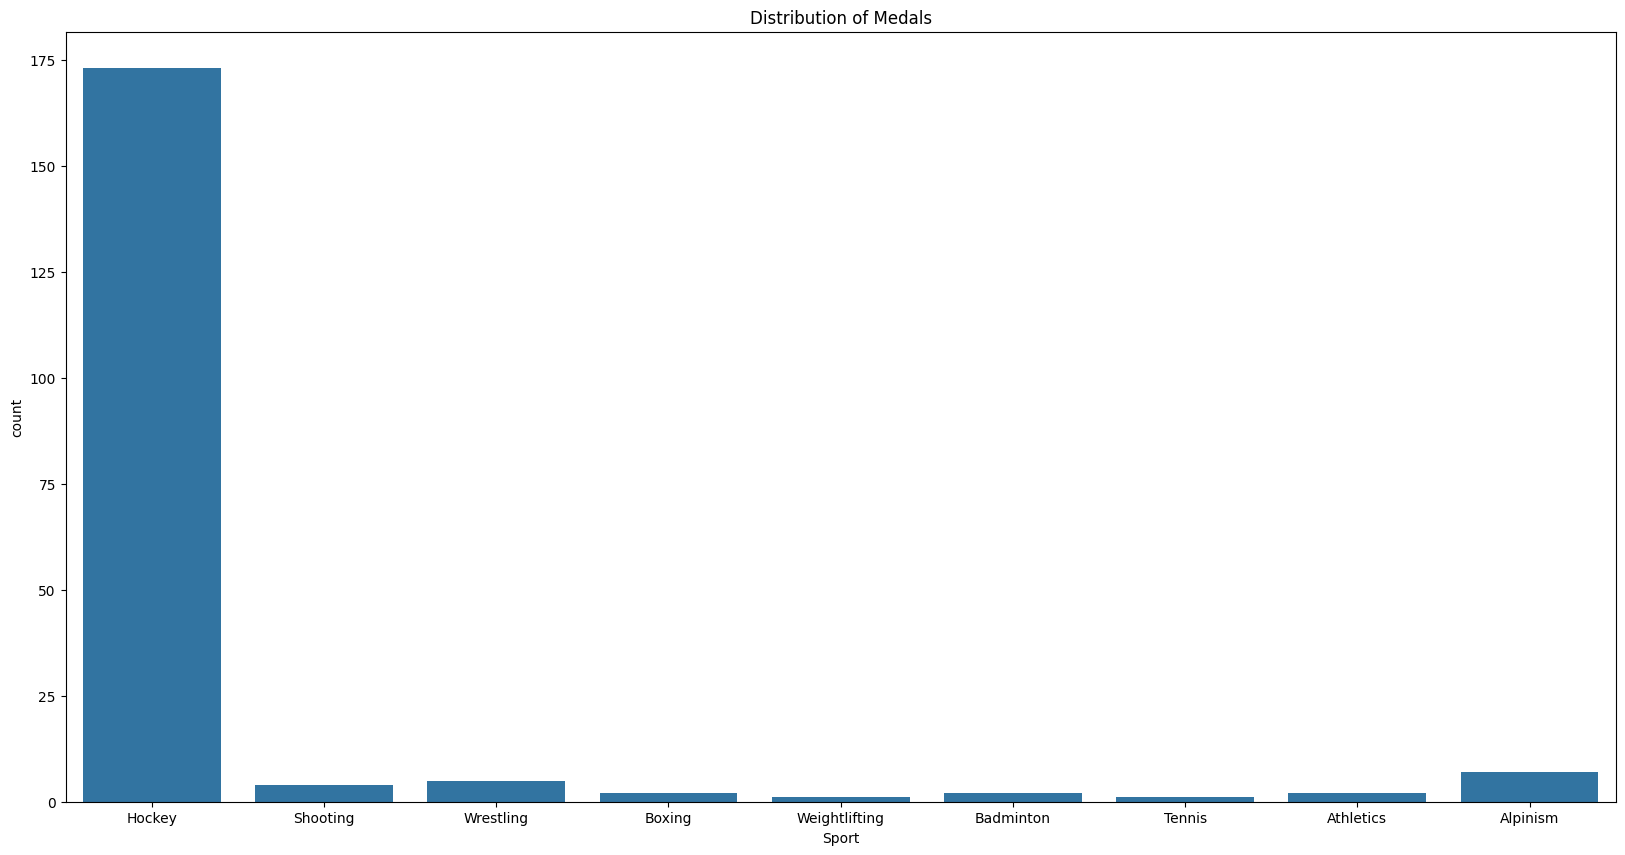

In [15]:
plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.countplot(x='Sport', data= dataIndia)
plt.title('Distribution of Medals')

In [16]:
hockeyPlayersMedal = dataIndia.loc[(dataIndia['Sport'] == 'Hockey')].sort_values(['Year'])
hockeyPlayersMedal.head(30)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
4732,2699,Shaukat Ali,M,30.0,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
221073,111081,Jaipal Singh Munda,M,25.0,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
215286,108082,Frederick Stephen Seaman,M,22.0,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
202266,101590,Michael E. Rocque,M,NaN,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
173081,86987,"Richard Alexander ""Rex"" Norris",M,28.0,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
150463,75490,George Eric McCarthy Marthins,M,22.0,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
116859,59150,"Feroz-ud-Din ""Feroze"" Khan",M,23.0,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
89524,45360,Leslie Charles Hammond,M,23.0,184.0,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
82144,41710,"William James ""Willie"" Goodsir-Cullen",M,21.0,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN
76886,39020,Michael Anthony Gateley,M,23.0,NaN,NaN,India,IND,1928 Summer,1928,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,NaN


## Let's count only one medal for a team in a particular game.

In [17]:
hockeyTeamMedal = hockeyPlayersMedal.groupby(['Year']).first()
hockeyTeamMedal.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Season,City,Sport,Event,Medal,region,notes
Year,,,,,,,,,,,,,,,,
1928,2699,Shaukat Ali,M,30.0,184.0,NaN,India,IND,1928 Summer,Summer,Amsterdam,Hockey,Hockey Men's Hockey,Gold,India,None
1932,118553,Carlyle Carrol Tapsell,M,23.0,182.0,NaN,India,IND,1932 Summer,Summer,Los Angeles,Hockey,Hockey Men's Hockey,Gold,India,None
1936,32514,Lionel Charles Renwick Emmett,M,23.0,182.0,NaN,India,IND,1936 Summer,Summer,Berlin,Hockey,Hockey Men's Hockey,Gold,India,None
1948,26677,Walter Louis Joseph de Sousa,M,27.0,162.0,53.0,India,IND,1948 Summer,Summer,London,Hockey,Hockey Men's Hockey,Gold,India,None
1952,98453,Muniswamy Rajagopal,M,26.0,162.0,53.0,India,IND,1952 Summer,Summer,Helsinki,Hockey,Hockey Men's Hockey,Gold,India,None


Now count the number of team medals in Hockey

In [18]:
hockeyTeamMedal['ID'].count()

11

Not bad! I have verified this with [Wikipedia page](https://en.wikipedia.org/wiki/India_men%27s_national_field_hockey_team)

And we have fixed the problem.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

Text(0.5, 1.0, 'Distribution of Medals by sports')

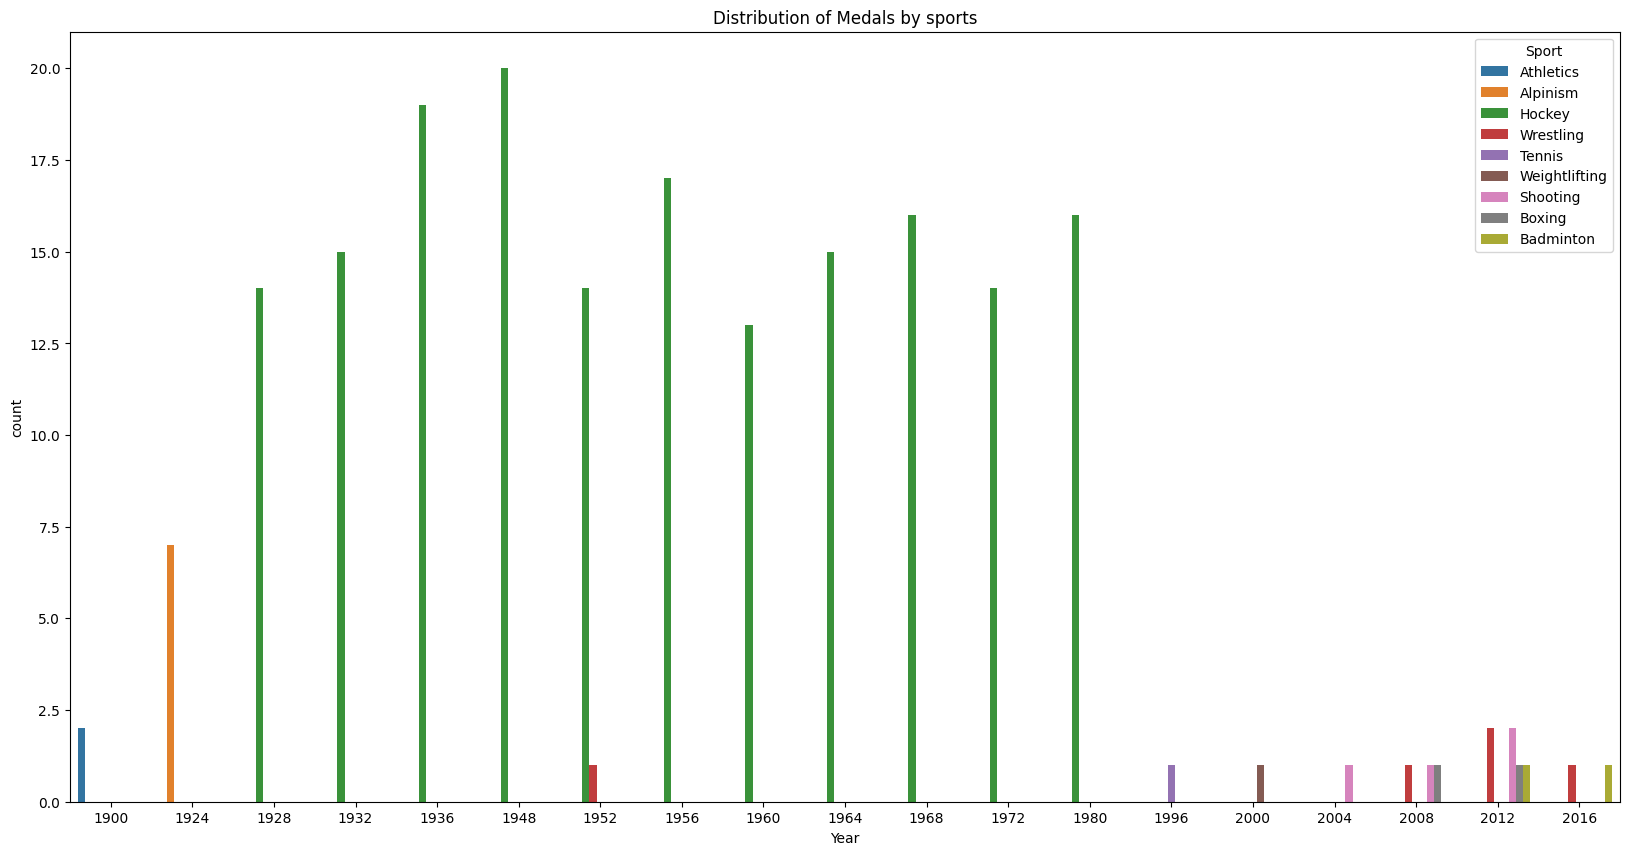

In [19]:
plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.countplot(x='Year', hue='Sport', data= dataIndia)
plt.title('Distribution of Medals by sports')

It seems like Indian youth lost interest in Hockey after 90's. Sad :(




# 7. Indian Women in Athletics



We can study the data and draw conclusions about the involvement of women in India


Let's create a filtered dataset:

In [20]:
womenInOlympics = merged[(merged.Sex == 'F') & (merged.NOC == 'IND')]

In [21]:
womenInOlympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
895,512,Shiny Kurisingal Abraham-Wilson,F,19.0,167.0,53.0,India,IND,1984 Summer,1984,Summer,Los Angeles,Athletics,Athletics Women's 800 metres,NaN,India,NaN
896,512,Shiny Kurisingal Abraham-Wilson,F,19.0,167.0,53.0,India,IND,1984 Summer,1984,Summer,Los Angeles,Athletics,Athletics Women's 4 x 400 metres Relay,NaN,India,NaN
897,512,Shiny Kurisingal Abraham-Wilson,F,23.0,167.0,53.0,India,IND,1988 Summer,1988,Summer,Seoul,Athletics,Athletics Women's 800 metres,NaN,India,NaN
898,512,Shiny Kurisingal Abraham-Wilson,F,23.0,167.0,53.0,India,IND,1988 Summer,1988,Summer,Seoul,Athletics,Athletics Women's 4 x 400 metres Relay,NaN,India,NaN
899,512,Shiny Kurisingal Abraham-Wilson,F,27.0,167.0,53.0,India,IND,1992 Summer,1992,Summer,Barcelona,Athletics,Athletics Women's 800 metres,NaN,India,NaN


Text(0.5, 1.0, 'Women participation per edition of the Games')

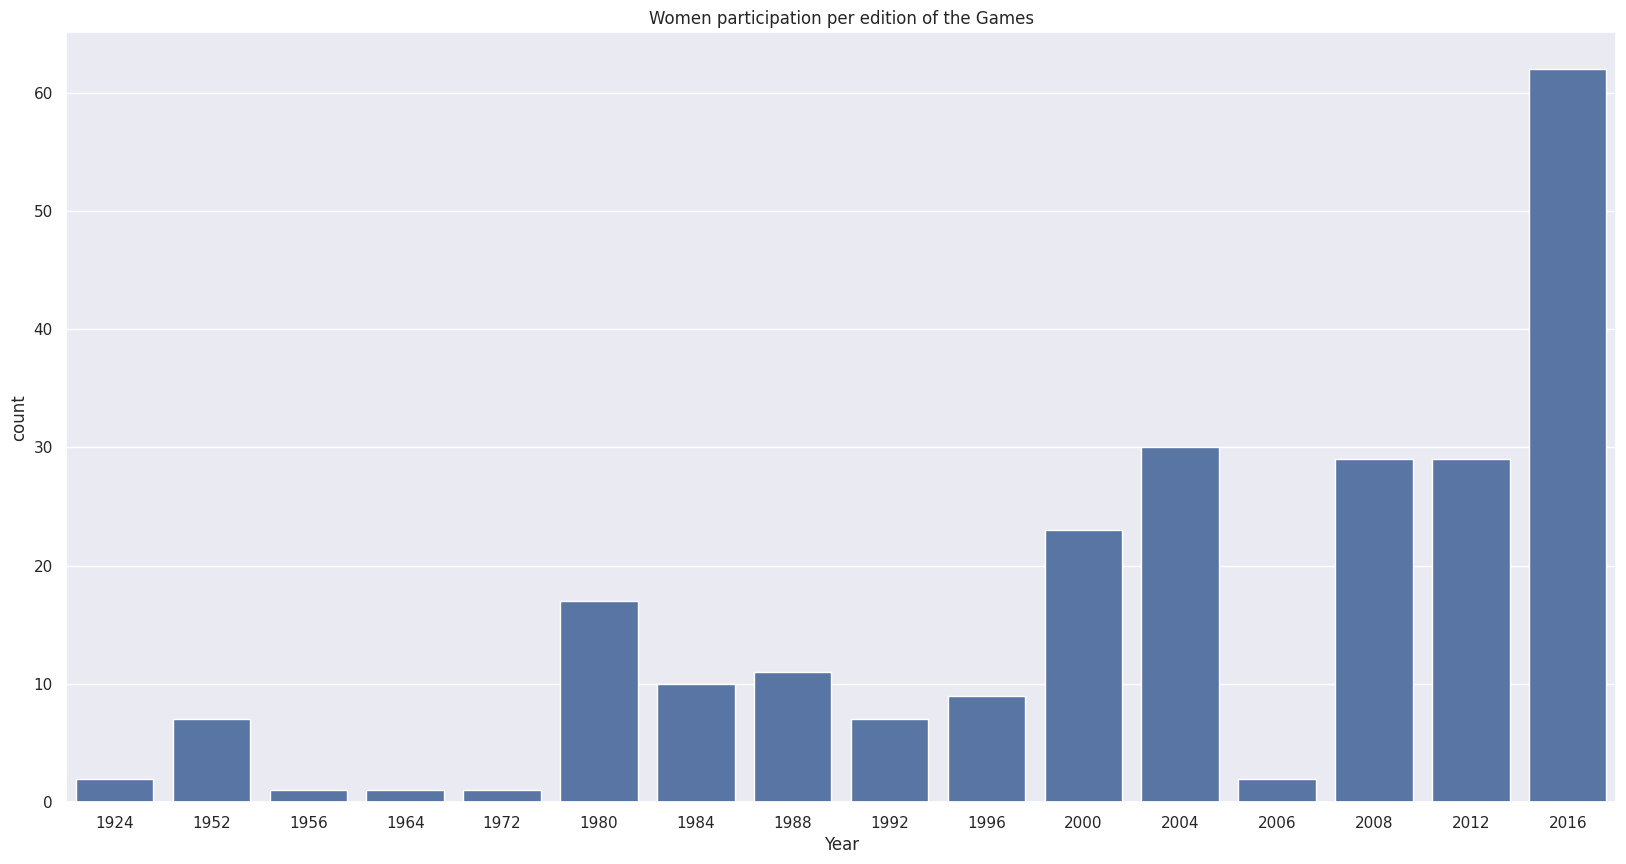

In [22]:
sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))
sns.countplot(x='Year', data=womenInOlympics)
plt.title('Women participation per edition of the Games')

It seems like Women started their journey way back from 1924 but Let's see when did the women wom their first medal.

In [23]:
womenInOlympics = dataIndia[dataIndia.Sex == 'F']
womenInOlympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
123303,62303,Mangte Chungneijang Mary Kom,F,29.0,158.0,51.0,India,IND,2012 Summer,2012,Summer,London,Boxing,Boxing Women's Flyweight,Bronze,India,NaN
147624,74069,Sakshi Malik,F,23.0,162.0,58.0,India,IND,2016 Summer,2016,Summer,Rio de Janeiro,Wrestling,"Wrestling Women's Lightweight, Freestyle",Bronze,India,NaN
147709,74119,Karnam Malleswari,F,25.0,163.0,60.0,India,IND,2000 Summer,2000,Summer,Sydney,Weightlifting,Weightlifting Women's Light-Heavyweight,Bronze,India,NaN
169313,85112,Saina Nehwal,F,22.0,167.0,65.0,India,IND,2012 Summer,2012,Summer,London,Badminton,Badminton Women's Singles,Bronze,India,NaN
220929,110974,"Pusarla Venkata ""P. V."" Sindhu",F,21.0,179.0,65.0,India,IND,2016 Summer,2016,Summer,Rio de Janeiro,Badminton,Badminton Women's Singles,Silver,India,NaN


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(0.5, 1.0, 'Women Medals per edition of the Games')

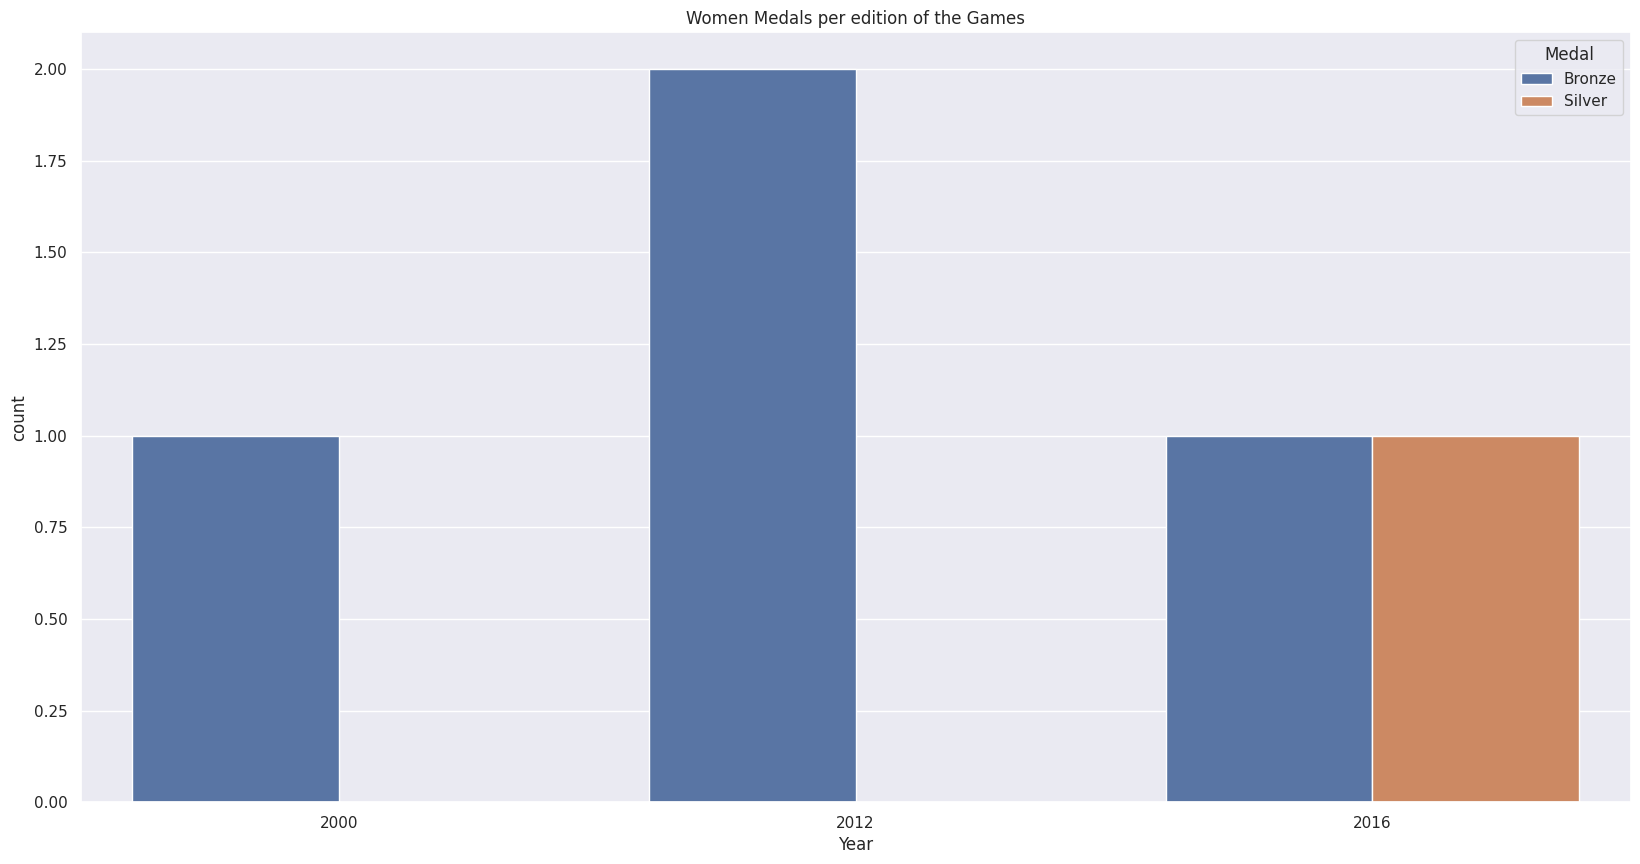

In [24]:
sns.set(style="darkgrid")
plt.figure(figsize=(20, 10))
sns.countplot(x='Year', hue='Medal', data=womenInOlympics)
plt.title('Women Medals per edition of the Games')

Women in India won their first medal in the year 2000 and continued to win more medals in the upcoming games.

# 8. Total Medals and number of Medals won by year








In [25]:
dataIndia.Medal.value_counts()

,count
Medal,
Gold,138
Bronze,40
Silver,19


It seems like Indians loved Gold.

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

Text(0.5, 1.0, 'Distribution of Medals by year')

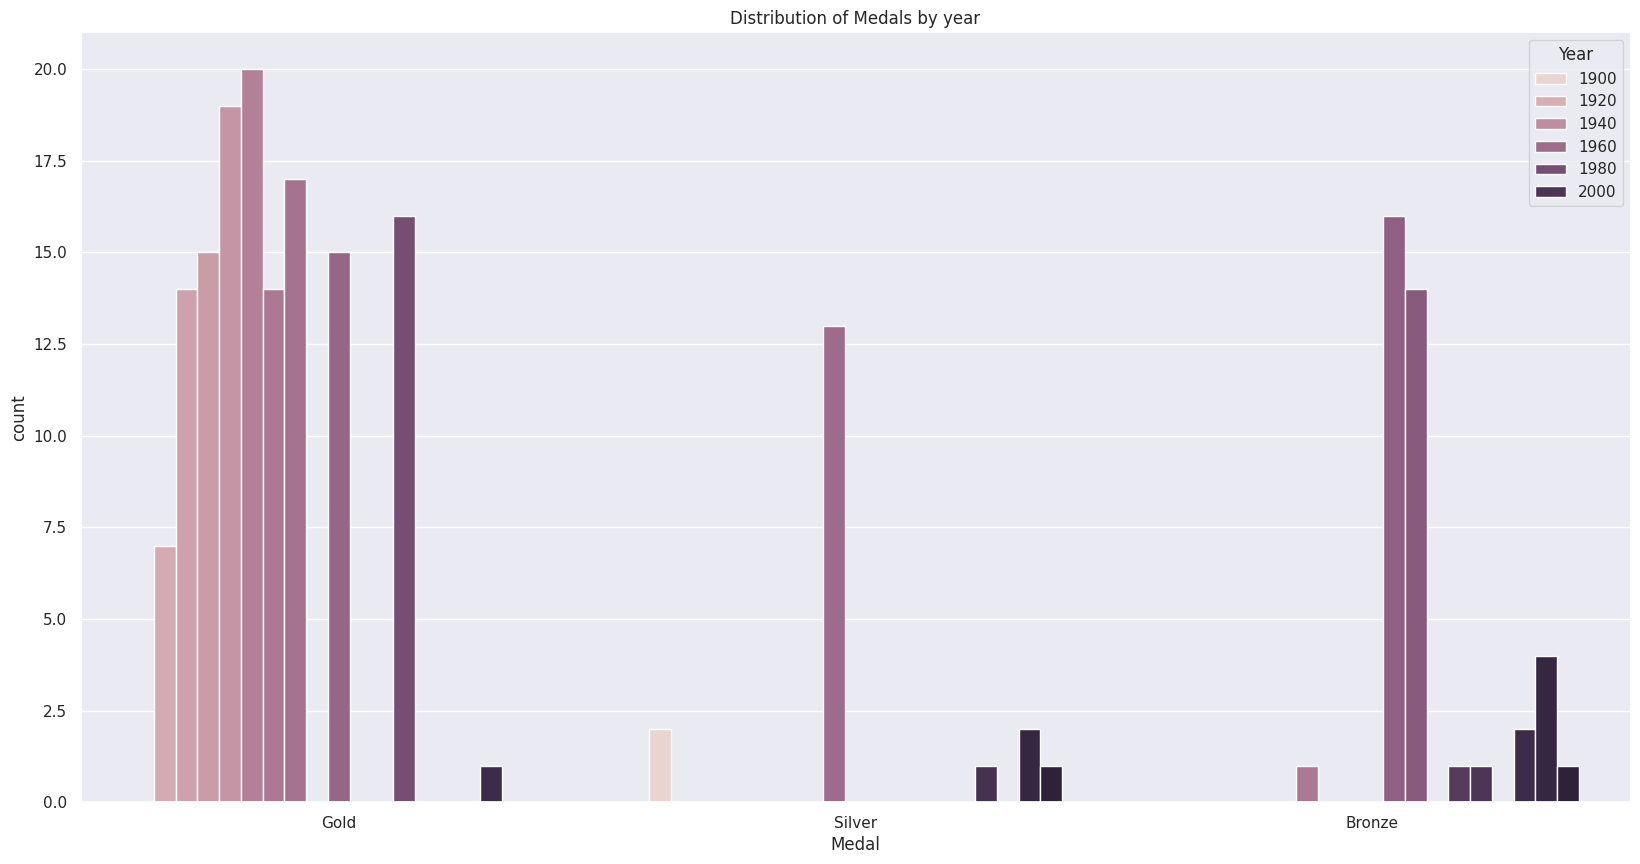

In [26]:
plt.figure(figsize=(20, 10))
plt.tight_layout()
sns.countplot(x='Medal', hue='Year', data= dataIndia)
plt.title('Distribution of Medals by year')

# 9. Conclusions

#### Thank you so much for reading. If you liked my work, please, upvote! This is my first kernel and I will be sharing more of my work regularly from now.

I will review and update the kernel periodically following your feedbacks.


Got a question? Ask me! :)